# Transient Fickian Diffusion with Reaction
`OpenPNM` supports adding reaction terms to both steady state and transient simulations. `OpenPNM` already includes many different source term models that can be added to simulate a reaction. In this example, we show how to add a `powerlaw` source term model to a transient fickian diffusion simulation.

Start by importing openpnm

In [1]:
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
ws = op.Workspace()
proj = ws.new_project()
np.random.seed(10)

## Define network, geometry, and phase objects

In [2]:
shape = [25, 25, 1]
net = op.network.Cubic(shape=shape, spacing=1e-2)
geo = op.geometry.SpheresAndCylinders(network=net, pores=net.Ps, throats=net.Ts)
phase = op.phases.Water(network=net)

You can adjust the diffusion coefficient by calling the `pore.diffusivity` dictionary key on the phase object and then setting it's value.

In [3]:
phase['pore.diffusivity'] = 2e-07

## Define physics object 
Here, we will use `Standard` physics which already includes many standard models. You could also use `Generic` physics and add neccessary models like `throat.diffusive_conductance` after using `phys.add_model()` method.

In [4]:
phys = op.physics.Standard(network=net, phase=phase, geometry=geo)

## Add reaction model 
Add reaction model to physics object. For this example we use the `powerlaw` reaction model which is of the form:

\begin{equation*}
\ A_1X^{A_2}
\end{equation*}

In [5]:
phase['pore.concentration'] = 0
phys['pore.rxnA'] = -1e-10
phys['pore.rxnb'] = 1
phys.add_model(propname='pore.reaction', model=op.models.physics.generic_source_term.power_law,
               A1='pore.rxnA', A2='pore.rxnb', X='pore.concentration')

## Define transient fickian diffusion object 

In [6]:
tfd = op.algorithms.TransientFickianDiffusion(network=net, phase=phase)

## Setup the transient algorithm settings
To do this you can call the `tfd.setup()` method and use it to set settings such as transient solver scheme, final time, time step, tolerance, etc. The `cranknicolson` scheme used here is the most accurate but slowest. Other time schemes are `implicit` which is faster but less accurate and `steady` which gives the steady state solution. 

In [7]:
x0 = 0
tspan = (0, 2000)
saveat = 100

## Set value boundary conditions
In this example we set the concentraton of the `front` pores to 1 and the concentration of the `back` pores to 0.

In [8]:
tfd.set_value_BC(pores=net.pores('front'), values=1)
tfd.set_value_BC(pores=net.pores('back'), values=0)

## Set initial condition
Initial conditions must be specified when `alg.run` is called as `alg.run(x0=x0)`, where `x0` could either be a scalar (in which case it'll be broadcasted to all pores), or an array.

## Set source term
In this example, we apply the source term to pores 212 and 412. 

In [9]:
tfd.set_source(propname='pore.reaction', pores=[212, 412])

## Run the simulation

In [10]:
tfd.run(x0=x0, tspan=tspan, saveat=saveat)

TransientSolution([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
                    ...,  1.00000000e+00,  1.00000000e+00,
                     1.00000000e+00],
                   [ 0.00000000e+00,  2.91319071e-01,  3.84896374e-01,
                    ...,  5.97301811e-01,  6.02342803e-01,
                     6.07187222e-01],
                   [ 0.00000000e+00,  5.74628159e-03,  1.67430291e-02,
                    ...,  1.99375746e-01,  2.08124985e-01,
                     2.16637037e-01],
                   ...,
                   [ 0.00000000e+00, -1.06917238e-40,  6.55640559e-33,
                    ...,  4.50327653e-14,  1.08254797e-13,
                     2.45573242e-13],
                   [ 0.00000000e+00, -1.26070992e-42,  2.61542193e-34,
                    ...,  9.18955938e-15,  2.27605268e-14,
                     5.30703578e-14],
                   [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                    ...,  0.00000000e+00,  0.00000000e+00,
      

## Visualize results
Ater simulation runs we can visualize results using a colour plot from `matplotlib.pyplot`. Here we visualize the results at the final time `t_final` by using the `pore.concentration` key on the algorithm object.

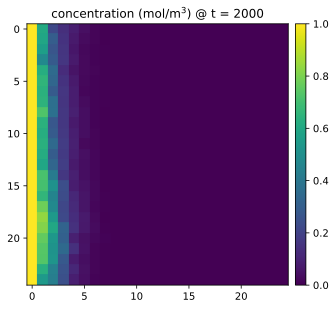

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

c = tfd['pore.concentration'].reshape(shape)
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(c[:,:,0])
ax.set_title(f'concentration (mol/m$^3$) @ t = {tspan[1]}')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
plt.colorbar(im, cax=cax);

If we print the `TransientFickianDiffusion` object we can see a list of the object's properties. Notice how the concentration is recorded here for each output concentration, `t_output`.

In [12]:
print(tfd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : alg_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_rate                                      0 / 625  
2     pore.bc_value                                    50 / 625  
3     pore.concentration                              625 / 625  
4     pore.ic                                         625 / 625  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      625       
2     pore.reaction                                 2         
3     throat.all         

We can visualize intermediate concentration profiles using a colour plot but use `pore.concentration@100` (or similar) as the dictionary key on the algorithm object.

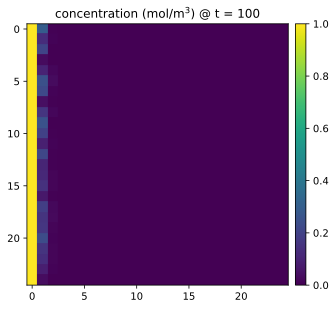

In [13]:
c = tfd.soln(100).reshape(shape)
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(c[:,:,0])
ax.set_title(f'concentration (mol/m$^3$) @ t = 100')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
plt.colorbar(im, cax=cax);